In [299]:
import os
os.environ['OMP_NUM_THREADS'] = "1"
import firedrake as fd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import vtk
import pyvista as pv
import gmsh
from firecracker import *

def get_vtk_unstructured_tet_grid(nodes, tetrahedra):

    number_of_cells = tetrahedra.shape[0]
    nodes_per_cell = 4

    # Each cell in the cell array needs to include the size of the cell
    # and the points belonging to the cell
    cells_size_array = np.full(
        (number_of_cells, 1), nodes_per_cell, dtype=np.int64)
    cells_for_vtk = np.append(
        cells_size_array, tetrahedra, axis=1).ravel().astype(int)
    # each cell is a VTK_TETRA
    celltypes = np.full(number_of_cells, vtk.VTK_TETRA, dtype=np.uint8)

    return pv.UnstructuredGrid(cells_for_vtk, celltypes, nodes)

def get_vtk_unstructured_tri_grid(nodes, triangles):

    number_of_cells = triangles.shape[0]
    nodes_per_cell = 3

    # Each cell in the cell array needs to include the size of the cell
    # and the points belonging to the cell
    cells_size_array = np.full(
        (number_of_cells, 1), nodes_per_cell, dtype=np.int64)
    cells_for_vtk = np.append(
        cells_size_array, triangles, axis=1).ravel().astype(int)
    # each cell is a VTK_TETRA
    celltypes = np.full(number_of_cells, vtk.VTK_TRIANGLE, dtype=np.uint8)

    return pv.UnstructuredGrid(cells_for_vtk, celltypes, nodes)

def cell_project(v, V, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor', 'ksp_converged_reason': None}):
    """
    Project an expression `v` into a cell-based function space `V`.
    
    If `v` is a dictionary then we can project different expressions
    on regions with different cell tags.
    
    The default solver parameters apply conjugate gradients as an
    iterative linear solver, with successive over-relaxation as a
    preconditioner.
    """
    v_, dv = fd.TestFunction(V), fd.TrialFunction(V)
    a = fd.inner(v_, dv)*fd.dx
    if isinstance(v, dict):
        L = sum([fd.inner(v_, val)*fd.dx(reg) for (reg, val) in v.items()])
    else:
        L = fd.inner(v_, v)*fd.dx
    u = fd.Function(V)
    fd.solve(a == L, u, solver_parameters=solver_parameters)
    return u

def facet_project(v, V, solver_parameters={'ksp_type': 'cg', 'pc_type': 'jacobi', 'ksp_converged_reason': None}):
    """
    Project an expression `v` into a facet-based function space `V`.
    
    If `v` is a dictionary then we can project different expressions
    on regions with different facet tags.
    
    The default solver parameters apply conjugate gradients as an
    iterative linear solver, with Jacobi as a preconditioner.
    """
    v_, dv = fd.TestFunction(V), fd.TrialFunction(V)
    a = fd.inner(fd.avg(v_), fd.avg(dv))*fd.dS
    if isinstance(v, dict):
        L = sum([fd.inner(fd.avg(v_), val)*fd.dS(reg) for (reg, val) in v.items()])
    else:
        L = fd.inner(fd.avg(v_), v)*fd.dS
    u = fd.Function(V)
    fd.solve(a == L, u, solver_parameters=solver_parameters)
    return u

def write_displaced_mesh_vtk(mesh, u, filename, fileds_list=[], scaling_factor=1):
    S1s_e = fd.FunctionSpace(mesh, "DG", 1)  # space for piecewise constant material properties
    x, y = fd.SpatialCoordinate(mesh)
    eicx, eicy = fd.Function(S1s_e).interpolate(x).dat.data, fd.Function(S1s_e).interpolate(y).dat.data
    eic = np.vstack([eicx,eicy]).T
    eux, euy = fd.Function(S1s_e).assign(u.sub(0)).dat.data, fd.Function(S1s_e).assign(u.sub(1)).dat.data
    eu = np.vstack([eux,euy]).T
    # Displaced coordinates
    ecc = eic + eu * scaling_factor
    ecc = np.hstack([ecc, np.zeros((ecc.shape[0],1))])
    triangles = np.arange(eu.shape[0]).reshape(eu.shape[0]//3,3)
    vtk_object = get_vtk_unstructured_tri_grid(ecc, triangles)
    # Adding fields
    vtk_object.point_data['Displacement'] = eu
    for field in fileds_list:
        vtk_object.point_data[field.name()] = fd.Function(S1s_e).interpolate(field).dat.data
    vtk_object.save(f'{filename}.vtu')
    
def cylinder_mesh(sample_radius=.25, sample_length=1, mesh_size=.075, model_name="3d_cylinder"):
    gmsh.initialize()
    gmsh.option.setNumber("Mesh.MeshSizeMax", mesh_size)
    gmsh.option.setNumber("General.Verbosity", 0)
    gmsh.model.add(model_name)
    # Cylindrical volume that represents the intact sample
    cylinder_sample_tag = gmsh.model.occ.addCylinder(x=.0, y=.0, z=.0,
                                                    dx=.0, dy=.0, dz=sample_length,
                                                    r=sample_radius)
    gmsh.model.occ.synchronize()
    # 3 Bottom, 2 Top, 1 Side
    boundaries = gmsh.model.getBoundary([(3, cylinder_sample_tag)])
    # Volume: 301
    gmsh.model.addPhysicalGroup(3, [cylinder_sample_tag], 301)
    # Side: 201
    gmsh.model.addPhysicalGroup(2, [1], 201)
    # Top: 202
    gmsh.model.addPhysicalGroup(2, [2], 202)
    # Bottom: 203
    gmsh.model.addPhysicalGroup(2, [3], 203)
    gmsh.model.occ.synchronize()
    gmsh.model.mesh.generate(3)
    gmsh.write(model_name + '.msh')
    mesh = fd.Mesh(model_name + '.msh')
    return mesh

(1127, 2)


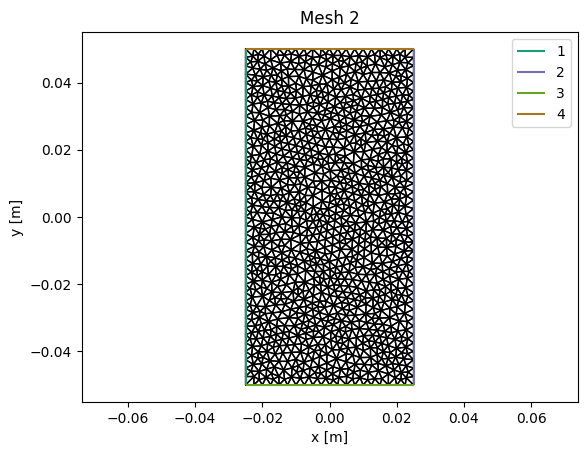

    Linear firedrake_35853_ solve converged due to CONVERGED_RTOL iterations 1
    Linear firedrake_35854_ solve converged due to CONVERGED_RTOL iterations 1
    Linear firedrake_35855_ solve converged due to CONVERGED_RTOL iterations 1
    Linear firedrake_35856_ solve converged due to CONVERGED_RTOL iterations 1


In [300]:
width, height = .05, .1
mesh_size = 0.0025

# load the mesh generated with Gmsh
mesh = mesh2d_rectangle(width, height, mesh_size,
                 filename = None, delete_mesh_file = True)
coords = mesh.coordinates.dat.data
print(coords.shape)
# Plot the mesh
fig1, ax1 = plt.subplots()
triplot(mesh, axes=ax1)
ax1.set_title("Mesh 2")

plt.legend()
plt.axis('equal')
ax1.set_ylim(-height*1.1/2, height*1.1/2)
ax1.set_xlim(-width*1.1/2, width*1.1/2)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
# Show the plot
plt.show()

dS = fd.dS
n = fd.FacetNormal(mesh)

V_u = fd.VectorFunctionSpace(mesh, "DG", 1)  # space for discontinuous displacement
V_f = fd.FunctionSpace(mesh, "HDiv Trace", 0)  # space for facet-based internal variables (maximum gap)
V_0 = fd.FunctionSpace(mesh, "DG", 0)  # space for piecewise constant material properties
S1s_e = fd.FunctionSpace(mesh, "DG", 1)  # space for piecewise constant material properties

u = fd.Function(V_u, name="Displacement")
u_, du = fd.TestFunction(V_u), fd.TrialFunction(V_u)
g_max = fd.Function(V_f, name="Maximum opening")
sigma_x = fd.Function(V_0, name="Sigma x")
sigma_y = fd.Function(V_0, name="Sigma y")
sigma_xy = fd.Function(V_0, name="Sigma xy")

# Assigning material properties
E_list = {1: 30e9}
E = cell_project(E_list, V_0)
nu_list = {1: 0.25}
nu = cell_project(nu_list, V_0)
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
Gc_list = {-1: 3.0}
Gc = fd.avg(facet_project(Gc_list, V_f))
sig_list = {-1: 3e6}
sig_max = fd.avg(facet_project(sig_list, V_f))
delta_0 = Gc/sig_max/fd.exp(1)
beta = fd.Constant(2.)
j_pen = fd.Constant(1e10)
pen = fd.Constant(1e11)

# Constitutive law
def eps(v):
    return fd.sym(fd.grad(v))
def sigma(v):
    d = mesh.geometric_dimension()
    return lmbda*fd.tr(eps(v))*fd.Identity(d) + 2*mu*eps(v)
# Cohesive law
def normal_opening(v, n):
    return fd.dot(v, n)
def tangential_opening(v, n):
    return v - normal_opening(v, n)*n
def effective_opening(v, n):
    return fd.sqrt(normal_opening(v, n)**2 + beta**2*tangential_opening(v, n)**2)
def ppos(x):
    return (x+abs(x))/2.
def nneg(x):
    return (x-abs(x))/2.
def T(opening, g_max, n):
    return Gc/delta_0**2*fd.exp(-g_max/delta_0)*opening + j_pen * nneg(normal_opening(opening, n)) * n

top_plate_u = fd.Constant(fd.as_vector([0, 0]))
bottom_plate_u = fd.Constant(fd.as_vector([0, 0]))
confinement = fd.Constant(.75e6)

top_BC = pen * fd.dot(u_, (u - top_plate_u))*fd.ds(4)
bottom_BC = pen * fd.dot(u_, (u - bottom_plate_u))*fd.ds(3)
radial_BC = confinement * fd.dot(n,u_)*fd.ds((1,2))

F = fd.inner(sigma(u), eps(u_))*fd.dx +\
    fd.inner(T(fd.jump(u), fd.avg(g_max), n("-")), fd.jump(u_))*fd.dS +\
    top_BC + bottom_BC + radial_BC

# We tell PETSc to just apply a preconditioner instead of using an iterative linear solver.
# The preconditioner is a full LU decomposition, meaning we are using a direct method that should be exact.
sp = {
    "snes_monitor": None,
    "ksp_type": "preonly",
    "ksp_monitor": None,
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}

# Create a linear solver object
nonlin_problem = fd.NonlinearVariationalProblem(F, u)
nonlin_solver = fd.NonlinearVariationalSolver(nonlin_problem, solver_parameters=sp)


In [301]:
Nincr = 1300
Niter_max = 200
output_frequncy = 10
tol = 1e-4
opening = [[0, 0]]
axial_stress = []
axial_strain = []
radial_strain = []
iterations = []

ffile = fd.File("output/czm_results.pvd")
for i in range(Nincr):
    try:
        clear_output(wait=True)
        print("Load step", i+1)
        top_plate_u.assign(fd.as_vector([0, -0.0000005*i]))
        bottom_plate_u.assign(fd.as_vector([0, 0.0000005*i]))
        nRes = 1.
        nonlin_solver.solve()
        g_max.assign(facet_project(effective_opening(fd.jump(u), n("-")), V_f))
        sigma_x.assign(fd.interpolate(sigma(u)[0,0], V_0))
        sigma_y.assign(fd.interpolate(sigma(u)[1,1], V_0))
        sigma_xy.assign(fd.interpolate(sigma(u)[1,1], V_0))
        
        clear_output(wait=True)
        axial_stress.append(.5*(abs(fd.assemble(sigma(u)[1, 1]*fd.ds(3)))+abs(fd.assemble(sigma(u)[1, 1]*fd.ds(4))))/width)
        axial_strain.append(fd.assemble(u[1]*fd.ds(3) - u[1]*fd.ds(4))/(height*width))
        radial_strain.append(fd.assemble(u[0]*fd.ds(1) - u[0]*fd.ds(2))/(width*height))
        if i%output_frequncy == 0:
            ffile.write(u, sigma_x, sigma_y, sigma_xy)
            #write_displaced_mesh_vtk(mesh, u, f"output/czm_displaced_{int(i/output_frequncy)}", fileds_list=[sigma_x, sigma_y], scaling_factor=100)
        if axial_strain[-1] > 0.001:
            ffile.write(u, sigma_x, sigma_y, sigma_xy)
            break
    except:
        break
    
    #write_displaced_mesh_vtk(mesh, u, f"output/czm_displaced_{i}", fileds_list=[sigma_x, sigma_y, sigma_z], scaling_factor=1)

Load step 109
    0 SNES Function norm 3.241150635911e+04 
      Residual norms for firedrake_35857_ solve.
      0 KSP Residual norm 3.241150635911e+04 
      1 KSP Residual norm 3.666277358968e-09 
    1 SNES Function norm 4.931071934731e+01 
      Residual norms for firedrake_35857_ solve.
      0 KSP Residual norm 4.931071934731e+01 
      1 KSP Residual norm 1.661849562412e-11 
    2 SNES Function norm 3.998907061078e-08 
    Linear firedrake_35966_ solve converged due to CONVERGED_RTOL iterations 1


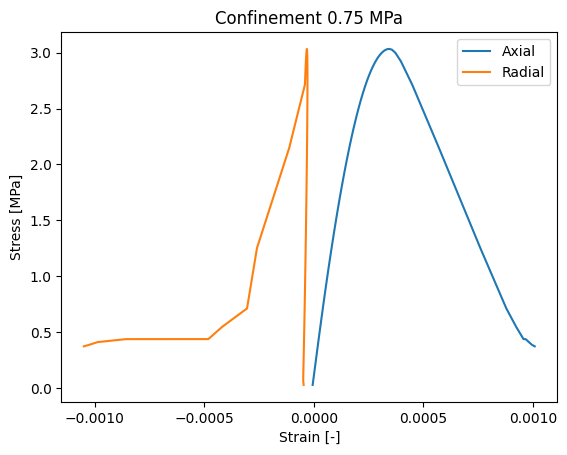

In [302]:
plt.plot(axial_strain, 1e-6*np.array(axial_stress), label='Axial')
plt.plot(-np.array(radial_strain), 1e-6*np.array(axial_stress), label='Radial')
plt.xlabel('Strain [-]')
plt.ylabel('Stress [MPa]')
plt.title(f'Confinement {confinement.values()[0]/1e6} MPa')
plt.legend();

In [303]:
axial_strain

[-5.791213275077083e-06,
 -3.238976918027752e-06,
 -7.268809756546032e-07,
 1.7753561369658637e-06,
 4.275988567552563e-06,
 6.777309946696114e-06,
 9.280613938647744e-06,
 1.1787008481003716e-05,
 1.4297527182680646e-05,
 1.6813141196346993e-05,
 1.9334758580401092e-05,
 2.186322307843838e-05,
 2.4399314131478585e-05,
 2.6943748440883474e-05,
 2.9497183029644042e-05,
 3.206021957606143e-05,
 3.4633409702834205e-05,
 3.721726087443517e-05,
 3.981224257134833e-05,
 4.2418792455796987e-05,
 4.5037322305702393e-05,
 4.7668223559973266e-05,
 5.031187238028056e-05,
 5.2968634187003854e-05,
 5.563886766771753e-05,
 5.832292828535618e-05,
 6.1021171331352674e-05,
 6.37339545786701e-05,
 6.646164059289768e-05,
 6.920459875852687e-05,
 7.196320707380629e-05,
 7.473785376247151e-05,
 7.752893874505533e-05,
 8.033687500698334e-05,
 8.316208989559547e-05,
 8.600502637378062e-05,
 8.886614425414544e-05,
 9.174592143454819e-05,
 9.464485515336851e-05,
 9.75634632810146e-05,
 0.00010050228566281124,


In [304]:
axial_strain[-1]

0.0010076573397655262

In [1]:
tensile_strength=3e6
fracture_energy=3
dg_penalty=1e10

elastic_opening_displacement = tensile_strength / dg_penalty
damage_opening_displacement = 2 * fracture_energy / tensile_strength
critical_displacement = min(elastic_opening_displacement, damage_opening_displacement)
iteration_displacement = critical_displacement / 10

print(f"Element size: {d_el}")
print(f"Damage size: {d_damage}")

Element size: 0.0003
Damage size: 2e-06


In [2]:
0.0000005

5e-07

In [3]:
200%0

ZeroDivisionError: integer modulo by zero

  Linear firedrake_6_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_7_ solve converged due to CONVERGED_RTOL iterations 1


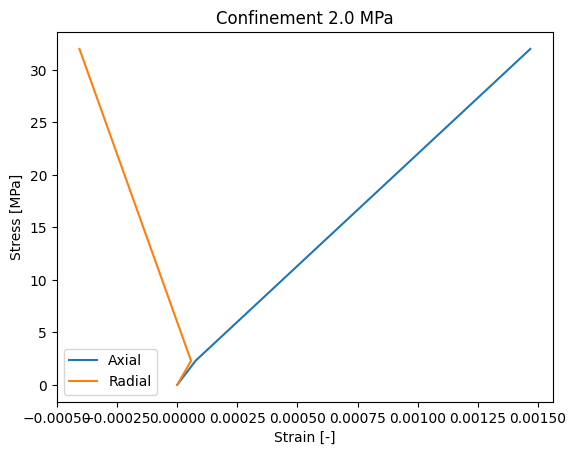

In [3]:
import forward_models as fm
curves = fm.elastic_triaxial_curves(confining_pressure=2e6, plot_output=True)

In [2]:
curves.shape

(3, 382)

  Linear firedrake_0_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_2_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_3_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_5_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_6_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_7_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_8_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_9_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_10_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_11_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_12_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_13_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_14_ solve converged due to C

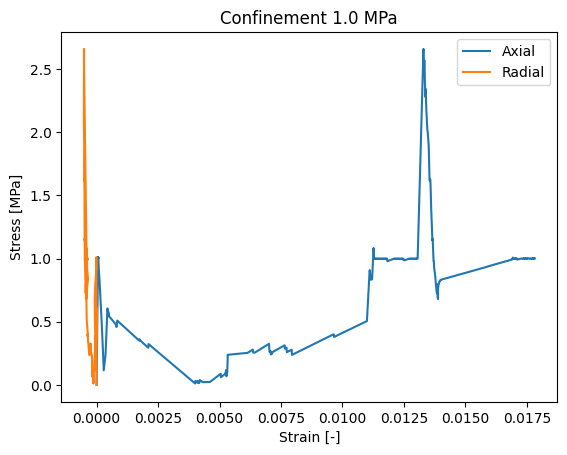

In [1]:
import forward_models as fm
curves = fm.cohesive_triaxial_curves(confining_pressure=1e6, plot_output=True)

In [6]:
curves[2]

array([6.01216842e-05, 6.16226588e-05, 6.16105970e-05, 6.14500635e-05,
       6.12748987e-05, 6.10984396e-05, 6.09220258e-05, 6.07457936e-05,
       6.05697581e-05, 6.03939222e-05, 6.02182875e-05, 6.00428553e-05,
       5.98676270e-05, 5.96926037e-05, 5.95177868e-05, 5.93431773e-05,
       5.91687763e-05, 5.89945847e-05, 5.88206036e-05, 5.86468337e-05,
       5.84732758e-05, 5.82999307e-05, 5.81267991e-05, 5.79538815e-05,
       5.77811784e-05, 5.76086904e-05, 5.74364178e-05, 5.72643609e-05,
       5.70925200e-05, 5.69208953e-05, 5.67494869e-05, 5.65782949e-05,
       5.64073193e-05, 5.62365601e-05, 5.60660172e-05, 5.58956904e-05,
       5.57255794e-05, 5.55556841e-05, 5.53860040e-05, 5.52165389e-05,
       5.50472882e-05, 5.48782516e-05, 5.47094285e-05, 5.45408184e-05,
       5.43724207e-05, 5.42042347e-05, 5.40362598e-05, 5.38684953e-05,
       5.37009405e-05, 5.35335946e-05, 5.33664568e-05, 5.31995264e-05,
       5.30328024e-05, 5.28662841e-05, 5.26999705e-05, 5.25338609e-05,
      

  Linear firedrake_782_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_783_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_784_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_785_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_787_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_788_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_789_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_790_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_791_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_792_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_793_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_794_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_795_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_796_ s

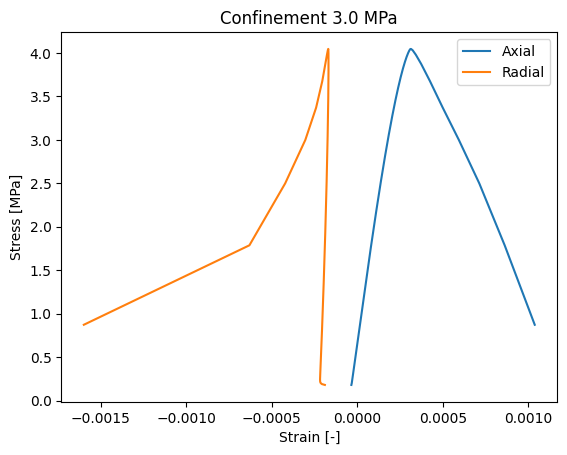

In [3]:
fm.cohesive_triaxial(confining_pressure=3e6)

  Linear firedrake_1571_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1572_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1573_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1574_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1576_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1577_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1578_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1579_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1580_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1581_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1582_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1583_ solve converged due to CONVERGED_RTOL iterations 1
  Linear firedrake_1584_ solve converged due to CONVERGED_RTOL iterations 1
  Linear fir

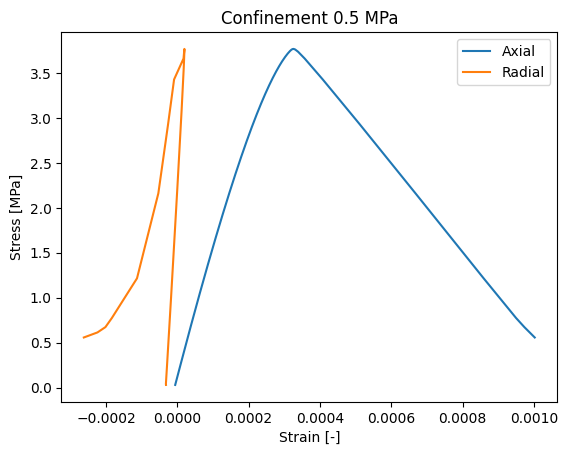

In [6]:
fm.cohesive_triaxial(confining_pressure=.5e6)